In [14]:
import os
import pandas as pd
import numpy as np
import wrds
from sec_edgar_downloader import Downloader
import re
from bs4 import BeautifulSoup
import statsmodels.formula.api as smf
from statsmodels.api import OLS

pre_10k_dir  = 'G:/10-K Filings/Pre'
post_10k_dir = 'G:/10-K Filings/Post'

pre_disclosure_companies  = pd.read_csv('pre_disclosure_companies.csv')
post_disclosure_companies = pd.read_csv('post_disclosure_companies.csv')

pre_keyword_data   = pd.read_csv('pre_keyword_data.csv')
post_keyword_data  = pd.read_csv('post_keyword_data.csv')

pre_post_keyword_data = pd.read_csv('pre_post_keyword_data.csv')
crsp_merged = pd.read_csv('crsp_merged.csv')

In [132]:
conn = wrds.Connection()
#lucginestet
#10yC*ZxJHp7X

Enter your WRDS username [lucgi]:lucginestet
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


### Download 10-Ks from SEC website

In [200]:
#retrieve data from crsp database
crsp = conn.raw_sql('''
                    select distinct
                        p.permno,
                        p.capn,
                        m.naics,
                        case when m.naics like '11%' then 'Agriculture, Forestry, Fishing and Hunting'
                             when m.naics like '21%' then 'Mining'
                             when m.naics like '22%' then 'Utilities'
                             when m.naics like '23%' then 'Construction'
                             when m.naics like '31%' then 'Manufacturing'
                             when m.naics like '32%' then 'Manufacturing'
                             when m.naics like '33%' then 'Manufacturing'
                             when m.naics like '42%' then 'Wholesale Trade'
                             when m.naics like '44%' then 'Retail Trade'
                             when m.naics like '45%' then 'Retail Trade'
                             when m.naics like '48%' then 'Transportation and Warehousing'
                             when m.naics like '49%' then 'Transportation and Warehousing'
                             when m.naics like '51%' then 'Information'
                             when m.naics like '52%' then 'Finance and Insurance'
                             when m.naics like '53%' then 'Real Estate Rental and Leasing'
                             when m.naics like '54%' then 'Professional, Scientific, and Technical Services'
                             when m.naics like '55%' then 'Management of Companies and Enterprises'
                             when m.naics like '56%' then 'Administrative and Support and Waste Management and Remediation Services'
                             when m.naics like '61%' then 'Educational Services'
                             when m.naics like '62%' then 'Health Care and Social Assistance'
                             when m.naics like '71%' then 'Arts, Entertainment, and Recreation'
                             when m.naics like '72%' then 'Accommodation and Food Services'
                             when m.naics like '81%' then 'Other Services (except Public Administration)'
                             when m.naics like '92%' then 'Public Administration'
                             else 'Not Found' end as industry,
                        case when s.permno is not null then 1 else 0 end as sp500,
                        m.ticker,
                        max(case when d.date = '2020-02-20' then d.prc end) as pre_covid_price,
                        max(case when d.date = '2020-03-20' then d.prc end) as covid_price, --date when S&P500 index fell sharply
                        max(case when d.date = '2020-03-27' then d.prc end) as week1_price,
                        max(case when d.date = '2020-04-20' then d.prc end) as month1_price,
                        max(case when d.date = '2020-06-22' then d.prc end) as month3_price,
                        max(case when d.date = '2020-09-21' then d.prc end) as month6_price,
                        max(case when d.date = '2020-12-21' then d.prc end) as month12_price
                    from
                        crsp.mport1 p
                        inner join crsp.msenames m
                            on p.permno = m.permno
                        inner join crsp.dsf d
                            on p.permno = d.permno
                        left join crsp.msp500list s
                            on p.permno = s.permno
                            and s.ending = '2020-12-31'
                    where
                        p.date = '2020-12-31'
                        and m.nameendt = '2020-12-31'
                        and d.date >= '2020-01-01'
                        and m.naics not like '61%'   --Health Care and Social Assistance
                        and m.naics not like '4242%' --Wholesale Drug
                        and m.naics not like '3391%' --Medical Equipment and Supplies Manufacturing
                        and m.naics not like '3254%' --Pharmaceutical and Medicine Manufacturing
                        and m.naics <> '423450'      --Medical, Dental, and Hospital Equipment and Supplies Merchant Wholesalers
                    group by
                        1,2,3,4,5,6
                    ''')

In [219]:
crsp

,permno,capn,naics,industry,sp500,ticker,pre_covid_price,covid_price,week1_price,month1_price,...,week1_mean_diff,month1_return,month1_mean_diff,month3_return,month3_mean_diff,month6_return,month6_mean_diff,month12_return,month12_mean_diff,pre_disclosure
0,10026.0,8.0,311813,Manufacturing,0,JJSF,174.580002,123.800003,114.559998,125.330002,...,-0.168283,0.012359,-0.164107,0.019305,-0.539000,0.031745,-0.675551,0.243942,-1.100804,0
1,10028.0,2.0,423940,Wholesale Trade,0,ELA,2.660000,2.600000,2.400000,3.100000,...,-0.170569,0.192308,0.015842,0.642308,0.084002,0.661539,-0.045758,0.746154,-0.598591,0
2,10032.0,8.0,334418,Manufacturing,0,PLXS,74.440002,43.000000,51.139999,56.869999,...,0.095656,0.322558,0.146092,0.516744,-0.041562,0.612093,-0.095203,0.795814,-0.548931,0
3,10044.0,2.0,311351,Manufacturing,0,RMCF,8.440000,3.770000,5.150000,4.511800,...,0.272401,0.196764,0.020298,0.257294,-0.301011,-0.209549,-0.916845,0.061008,-1.283737,1
4,10051.0,7.0,621498,Health Care and Social Assistance,0,HNGR,24.520000,13.000000,14.270000,17.280001,...,0.004046,0.329231,0.152765,0.309231,-0.249075,0.399231,-0.308065,0.736154,-0.608592,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4963,93423.0,9.0,713110,"Arts, Entertainment, and Recreation",0,SIX,31.889999,11.800000,13.950000,15.670000,...,0.088557,0.327966,0.151500,0.823729,0.265423,0.866949,0.159653,1.794068,0.449323,0
4964,93426.0,5.0,334416,Manufacturing,0,VPG,30.990000,17.950001,19.280001,21.240000,...,-0.019552,0.183287,0.006821,0.304178,-0.254128,0.354317,-0.352979,0.677437,-0.667308,0
4965,93427.0,8.0,333314,Manufacturing,0,FN,63.240002,47.779999,48.340000,61.200001,...,-0.081926,0.280871,0.104405,0.264337,-0.293969,0.301591,-0.405705,0.557765,-0.786981,1
4966,93434.0,2.0,111998,"Agriculture, Forestry, Fishing and Hunting",0,SANW,2.456400,2.190000,2.100000,1.910000,...,-0.134742,-0.127854,-0.304320,0.009132,-0.549173,0.424657,-0.282639,0.337900,-1.006846,1


In [17]:
print(len(crsp[crsp['sp500'] == 1]),'S&P 500 companies that are not in industries that are likely to discuss pandemic-related terms as an artifact of their operations.')

467 S&P 500 companies that are not in industries that are likely to discuss pandemic-related terms as an artifact of their operations.


In [18]:
#download pre-covid 10-K filings
pre_10ks = Downloader(pre_10k_dir)

for ticker in crsp.ticker:
    pre_10ks.get('10-K',ticker,amount=1,before='2019-01-01',download_details=False)

In [19]:
#list all .txt files under pre-covid 10-Ks directory
pre_txt_files = [os.path.join(root,name)
                 for root,dirs,files in os.walk(pre_10k_dir)
                 for name in files
                 if name.endswith('.txt',)]

In [22]:
#create list of S&P500 company tickers
pre_10k_tickers = []

for file in pre_txt_files:
    #get ticker symbol of company from file path
    pre_10k_start = file.find('sec-edgar-filings\\') + len('sec-edgar-filings\\')
    pre_10k_end   = file.find('\\10-K')
    pre_10k_ticker  = file[pre_10k_start:pre_10k_end]
    pre_10k_tickers.append(pre_10k_ticker)

In [23]:
#download latest 10-K filings for every pre-covid filing
post_10ks = Downloader(post_10k_dir)

for ticker in pre_10k_tickers:
    post_10ks.get('10-K',ticker,amount=1,download_details=False)

In [24]:
post_txt_files = [os.path.join(root,name)
                  for root,dirs,files in os.walk(post_10k_dir)
                  for name in files
                  if name.endswith('.txt',)]

In [25]:
#check to make sure we have the same number of company 10-Ks in each list
print(len(pre_txt_files) == len(post_txt_files))

True


In [27]:
print(len(pre_txt_files),'public companies have a 10-K filing before 2019-01-01')

3279 public companies have a 10-K filing before 2019-01-01


### Changes in pandemic related risk disclosures pre and post covid

In [28]:
keywords = [' pandemic ',
            ' epidemic ',
            ' corona virus ',
            ' contagious disease ',
            ' contagious illness ',
            ' infectious disease ',
            ' infectious outbreak ',
            ' fear of contagion ',
            ' influenza virus ',
            ' avian flu ',
            ' h1n1 ',
            ' swine flu ',
            ' mers ',
            ' ebola ',
            ' localized illnesses ',
            ' health concerns ',
            ' outbreak of disease ']

In [29]:
#create lists of all S&P500 company 10-K filings that contained risk factor section and pandemic related keywords within those sections before the covid-19 pandemic
pre_disclosure_companies = []
pre_keyword_tickers = []
pre_keywords = []
pre_keyword_counts = []

for file in pre_txt_files:
    pre_text         = open(file,encoding="utf8").read().lower()
    pre_nobreak_text = pre_text.replace('\n','')
    pre_final_text   = pre_nobreak_text.replace('.',' ')

    #get ticker symbol of company from file path
    pre_ticker_start  = file.find('sec-edgar-filings\\') + len('sec-edgar-filings\\')
    pre_ticker_end    = file.find('\\10-K')
    pre_full_ticker = file[pre_ticker_start:pre_ticker_end]

    if re.search('item.+1a.+risk.+factors',pre_final_text) != None:
        pre_disclosure_companies.append(pre_full_ticker)
        for word in keywords:
            #company must have risk factor section to be included
            if word in pre_final_text:
            #store ticker and keyword/count values for companies with matches as lists
                pre_keyword_tickers.append(pre_full_ticker)
                pre_keywords.append(word)
                pre_keyword_counts.append(pre_final_text.count(word))
    else:
        continue

In [31]:
#create lists of all S&P500 company 10-K filings that contained risk factor section and pandemic related keywords within those sections before the covid-19 pandemic
post_disclosure_companies = []
post_keyword_tickers = []
post_keywords = []
post_keyword_counts = []

for file in post_txt_files:
    post_text         = open(file,encoding="utf8").read().lower()
    post_nobreak_text = post_text.replace('\n','')
    post_final_text   = post_nobreak_text.replace('.',' ')

    #get ticker symbol of company from file path
    post_ticker_start  = file.find('sec-edgar-filings\\') + len('sec-edgar-filings\\')
    post_ticker_end    = file.find('\\10-K')
    post_full_ticker = file[post_ticker_start:post_ticker_end]

    if re.search('item.+1a.+risk.+factors',post_final_text) != None:
        post_disclosure_companies.append(post_full_ticker)
        for word in keywords:
            #company must have risk factor section to be included
            if word in post_final_text:
            #store ticker and keyword/count values for companies with matches as lists
                post_keyword_tickers.append(post_full_ticker)
                post_keywords.append(word)
                post_keyword_counts.append(post_final_text.count(word))
    else:
        continue

In [32]:
#combine keyword lists into dataframe and 
pre_keyword_data  = pd.DataFrame({'ticker':pre_keyword_tickers,
                                  'keyword':pre_keywords,
                                  'keyword count':pre_keyword_counts})

post_keyword_data = pd.DataFrame({'ticker':post_keyword_tickers,
                                  'keyword':post_keywords,
                                  'keyword count':post_keyword_counts})

pre_post_keyword_data = post_keyword_data.merge(pre_keyword_data,how='left',on='ticker',suffixes=('_post','_pre'))

crsp_merged = crsp.merge(pre_post_keyword_data,how='left',on='ticker')

In [34]:
#export keyword data to csv for faster future use
pre_disclosure_companies_df = pd.DataFrame(pre_disclosure_companies, columns=["companies"])
pre_disclosure_companies_df.to_csv('pre_disclosure_companies.csv')
post_disclosure_companies_df = pd.DataFrame(post_disclosure_companies, columns=["companies"])
post_disclosure_companies_df.to_csv('post_disclosure_companies.csv')

pre_keyword_data.to_csv('pre_keyword_data.csv')
post_keyword_data.to_csv('post_keyword_data.csv')

pre_post_keyword_data.to_csv('pre_post_keyword_data.csv')
crsp_merged.to_csv('crsp_merged.csv')

In [36]:
print(len(pre_disclosure_companies),
      '(',round(len(pre_disclosure_companies)/len(pre_txt_files)*100,1),'%)',
      'public companies have a risk factors section at the beginning of their 10-K before the Covid-19 pandemic.')
print(len(pd.unique(pre_keyword_data['ticker'])),
      '(',round((len(pd.unique(pre_keyword_data['ticker']))/len(pre_disclosure_companies))*100,1),'%)',
      'public companies have a pandemic related terms in the risk factors section of their 10-K before the Covid-19 pandemic.')

print(len(post_disclosure_companies),
      '(',round(len(post_disclosure_companies)/len(post_txt_files)*100,1),'%)',
      'public companies have a risk factors section at the beginning of their 10-K after the Covid-19 pandemic.')
print(len(pd.unique(post_keyword_data['ticker'])),
      '(',round((len(pd.unique(post_keyword_data['ticker']))/len(post_disclosure_companies))*100,1),'%)',
      'public companies have a pandemic related terms in the risk factors section of their 10-K after the Covid-19 pandemic.')

3241 ( 98.8 %) public companies have a risk factors section at the beginning of their 10-K before the Covid-19 pandemic.
423 ( 13.1 %) public companies have a pandemic related terms in the risk factors section of their 10-K before the Covid-19 pandemic.
3253 ( 99.2 %) public companies have a risk factors section at the beginning of their 10-K after the Covid-19 pandemic.
3101 ( 95.3 %) public companies have a pandemic related terms in the risk factors section of their 10-K after the Covid-19 pandemic.


In [37]:
pre_keyword_data_agg = pre_keyword_data.groupby(by='keyword').agg({'ticker':['count'],'keyword count':['sum']})
pre_keyword_data_agg.sort_values(by=('ticker','count'),ascending=False)

,ticker,keyword count
,count,sum
keyword,,
pandemic,172,308
health concerns,112,183
epidemic,92,174
infectious disease,59,143
h1n1,40,62
ebola,23,50
avian flu,20,28
outbreak of disease,18,24


In [38]:
post_keyword_data.groupby(by='keyword').agg({'ticker':['count'],'keyword count':['sum']}).sort_values(by=('ticker','count'),ascending=False)

,ticker,keyword count
,count,sum
keyword,,
pandemic,3089,95915
epidemic,408,788
health concerns,316,505
infectious disease,164,387
contagious disease,115,172
h1n1,50,104
ebola,32,64
outbreak of disease,30,44


In [67]:
#find companies that only declared pandemic related risks after covid
new_disclosure_companies = pre_post_keyword_data[pre_post_keyword_data['keyword_pre'].isna()]
new_disclosure_companies = new_disclosure_companies[['ticker']].drop_duplicates()

new_disclosure_industries = new_disclosure_companies.merge(crsp,how='inner',on='ticker')
new_disclosure_industries['short naics'] = new_disclosure_industries['naics'].str[:4]

<AxesSubplot:xlabel='industry'>

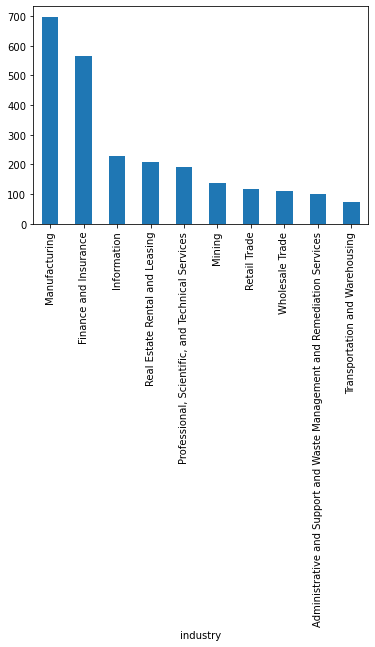

In [194]:
new_disclosure_industries_abs        = new_disclosure_industries.groupby('industry').count()
new_disclosure_industries_abs_sorted = new_disclosure_industries_abs.sort_values(by='ticker',ascending=False).head(10)
new_disclosure_industries_abs_final  = new_disclosure_industries_abs_sorted['ticker']
new_disclosure_industries_abs_final.plot.bar(rot=90)
#5221 - Depository Credit Intermediation
#5311 - Lessors of Residential Buildings and Dwellings
#5239 - Other Financial Investment Activities
#5112 - Software Publishers
#3344 - Semiconductor and Other Electronic Component Manufacturing
#5415 - Computer Systems Design and Related Services
#5241 - Insurance Carriers
#3345 - Navigational, Measuring, Electromedical, and Control Instruments Manufacturing
#2131 - Support Activities for Mining
#2111 - Oil and Gas Extraction

<AxesSubplot:xlabel='industry'>

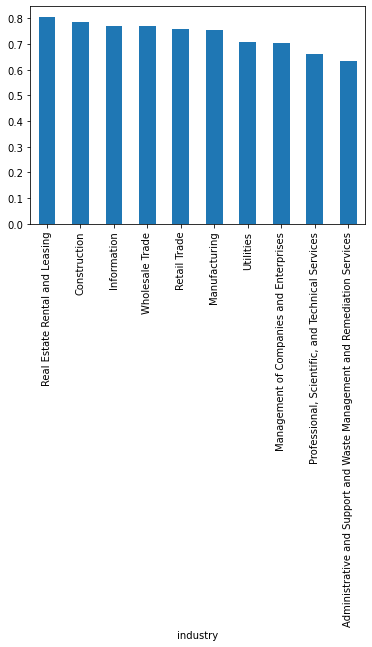

In [196]:
crsp_short_naics = crsp
crsp_short_naics['short naics'] = crsp_short_naics['naics'].str[:4]

industry_count = crsp_short_naics.groupby('industry').count()

industry_per = new_disclosure_industries_abs.merge(industry_count,how='inner',on='industry',suffixes=('_new','_total'))
industry_per['new_percent'] = (industry_per['ticker_new']/industry_per['ticker_total'])
industry_per_filtered = industry_per[industry_per['ticker_total']>25]
industry_per_sorted = industry_per_filtered.sort_values(by='new_percent',ascending=False).head(10)
industry_per_final  = industry_per_sorted['new_percent']
industry_per_final.plot.bar(rot=90)

### Compare stock performance between companies that did and did not disclose pandemic related risks

In [ ]:
#risk adjusted return
#jan, feb start date
#take price at start of pandemic and look 1 week, 1-3 months out
#capm
#use continuous variable to indicate intensity of disclosure
#total words or keywords/total words in filing

In [250]:
#create stock return columns and identifier if company disclosed pandemic related risks pre-covid
crsp_return = crsp

crsp_return['covid_return']   = (crsp_return['covid_price']-crsp_return['pre_covid_price'])/crsp_return['pre_covid_price']
covid_mean = crsp_return['covid_return'].mean()
crsp_return['covid_mean_diff'] = crsp_return['covid_return'] - covid_mean

crsp_return['week1_return']   = (crsp_return['week1_price']-crsp_return['covid_price'])/crsp_return['covid_price']
week1_mean = crsp_return['week1_return'].mean()
crsp_return['week1_mean_diff'] = crsp_return['week1_return'] - week1_mean

crsp_return['month1_return']  = (crsp_return['month1_price']-crsp_return['covid_price'])/crsp_return['covid_price']
month1_mean = crsp_return['month1_return'].mean()
crsp_return['month1_mean_diff'] = crsp_return['month1_return'] - month1_mean

crsp_return['month3_return']  = (crsp_return['month3_price']-crsp_return['covid_price'])/crsp_return['covid_price']
month3_mean = crsp_return['month3_return'].mean()
crsp_return['month3_mean_diff'] = crsp_return['month3_return'] - month3_mean

crsp_return['month6_return']  = (crsp_return['month6_price']-crsp_return['covid_price'])/crsp_return['covid_price']
month6_mean = crsp_return['month6_return'].mean()
crsp_return['month6_mean_diff'] = crsp_return['month6_return'] - month6_mean

crsp_return['month12_return'] = (crsp_return['month12_price']-crsp_return['covid_price'])/crsp_return['covid_price']
month12_mean = crsp_return['month12_return'].mean()
crsp_return['month12_mean_diff'] = crsp_return['month12_return'] - month12_mean

crsp_return['pre_disclosure'] = np.where(crsp_return['ticker'].isin(pre_keyword_data['ticker']),1,0)
crsp_return.dropna(subset=['pre_covid_price'],inplace=True)
crsp_return.dropna(subset=['month3_price'],inplace=True)
crsp_return.dropna(subset=['covid_price'],inplace=True)

In [251]:
#check to make sure we identified the correct acmount of pre disclosure companies
len(crsp_return[crsp_return['pre_disclosure']==1]) == len(pd.unique(pre_keyword_data['ticker']))

False

In [262]:
OLS(crsp_return['month1_mean_diff'],crsp_return['pre_disclosure']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       month1_mean_diff   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              4.129
Date:                Thu, 29 Apr 2021   Prob (F-statistic):                      0.0422
Time:                        02:46:36   Log-Likelihood:                         -5101.3
No. Observations:                4563   AIC:                                  1.020e+04
Df Residuals:                    4562   BIC:                                  1.021e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
pre_disclosure     0.0734      0.036      2.032      0.042       0.003       0.144
==============================================================================
Omnibus:                    10190.349   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         97213443.710
Skew:                          20.391   Prob(JB):                         0.00
Kurtosis:                     716.898   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [265]:
smf.ols(formula='covid_mean_diff~C(industry)+pre_disclosure+capn',data=test1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        covid_mean_diff   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.404
Date:                Thu, 29 Apr 2021   Prob (F-statistic):              0.110
Time:                        02:47:36   Log-Likelihood:                -820.89
No. Observations:                1657   AIC:                             1684.
Df Residuals:                    1636   BIC:                             1797.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================================
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                  -0.2603      0.100     -2.612      0.009      -0.456      -0.065
C(industry)[T.Administrative and Support and Waste Management and Remediation Services]     0.2242      0.108      2.069      0.039       0.012       0.437
C(industry)[T.Agriculture, Forestry, Fishing and Hunting]                                   0.4241      0.188      2.259      0.024       0.056       0.792
C(industry)[T.Arts, Entertainment, and Recreation]                                         -0.0162      0.164     -0.098      0.922      -0.339       0.306
C(industry)[T.Construction]                                                                 0.3396      0.146      2.322      0.020       0.053       0.626
C(industry)[T.Finance and Insurance]                                                        0.2419      0.097      2.489      0.013       0.051       0.432
C(industry)[T.Health Care and Social Assistance]                                            0.2742      0.120      2.294      0.022       0.040       0.509
C(industry)[T.Information]                                                                  0.2675      0.105      2.556      0.011       0.062       0.473
C(industry)[T.Management of Companies and Enterprises]                                      0.0710      0.124      0.573      0.566      -0.172       0.314
C(industry)[T.Manufacturing]                                                                0.2689      0.099      2.723      0.007       0.075       0.463
C(industry)[T.Mining]                                                                       0.2008      0.105      1.904      0.057      -0.006       0.408
C(industry)[T.Other Services (except Public Administration)]                                0.3200      0.170      1.880      0.060      -0.014       0.654
C(industry)[T.Professional, Scientific, and Technical Services]                             0.2577      0.102      2.518      0.012       0.057       0.458
C(industry)[T.Public Administration]                                                        0.3261      0.299      1.092      0.275      -0.260       0.912
C(industry)[T.Real Estate Rental and Leasing]                                               0.1570      0.109      1.442      0.150      -0.057       0.371
C(industry)[T.Retail Trade]                                                                 0.3361      0.114      2.959      0.003       0.113       0.559
C(industry)[T.Transportation and Warehousing]                                               0.2262      0.117      1.93